#**Cấu trúc**
1. Import dữ liệu
2. Xây dựng mô hình
3. Huấn luyện mô hình
4. Đánh giá mô hình

**chọn tài nguyên là TPU hoặc T4 GPU**

#**Import thư viện**

In [ ]:
# Tải mô hình phát hiện khuôn
!pip install face_recognition
import face_recognition


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=aef9c95085390b15414620b7b930f61f7d8c2ca0b3216ab6d68ab3015a1d1b2e
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
import os
import cv2
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from tensorflow.keras.models import load_model


# **Thiết lập các tham số**

In [ ]:
IMG_SIZE = [224, 224, 3]  # kích thước đầu vào

PIXEL_MEAN = [103.939, 116.779, 123.68] # BGR pixel mean value

NUM_CLASSES = 2           # số lượng lớp đầu ra

BKG_LABEL = 0             #

LEARNING_RATE = 0.001     # tốc độ học - xác định tốc độ cập nhật các trọng số trong quá trình tối ưu hóa mô hình.

DECAY_RATE = 0.95         # Tốc độ học sẽ bị giảm sau mốc sự kiện nhất định

NUM_EPOCHS = 20           # Một epoch đại diện cho một lần model đã được huấn luyện trên tất cả các mẫu trong tập dữ liệu huấn luyện

TRAIN_BATCH_SIZE = 64     # Dữ liệu huấn luyện thường được chia thành các batch (nhóm) để tăng tốc độ huấn luyện và tối ưu hóa


MODEL_DIR_PREFIX = 'ckpt' #

MODEL_NAME = 'model'      #

TEST_BATCH_SIZE = 8       #

#**Xây dựng mô hình**

**Cấu trúc của mạng VGG16**

1. Input Layer: Kích thước ảnh đầu vào x số kênh màu: 224x224x3
2. Convolutional Layer: số lượng kernel x kích thước kernel: 64x3x3, hàm activation là ReLU.
3. Conv: kernel 64x3x3, hàm ReLU.
4. Pooling Layer: Max pooling với kích thước pool là 2x2 và stride là 2.
5. Conv: kernel 128x3x3, hàm ReLU
6. Conv: kernel 128x3x3, hàm ReLU
7. Pooling Layer: Max pooling với kích thước pool là 2x2 và stride là 2.
6. Conv: kernel 256x3x3, hàm ReLU
6. Conv: kernel 256x3x3, hàm ReLU
6. Conv: kernel 256x3x3, hàm ReLU
11. Pooling Layer: Max pooling với kích thước pool là 2x2 và stride là 2.
6. Conv: kernel 512x3x3, hàm ReLU
6. Conv: kernel 512x3x3, hàm ReLU
6. Conv: kernel 512x3x3, hàm ReLU
15.Pooling Layer: Max pooling với kích thước pool là 2x2 và stride là 2.
6. Conv: kernel 512x3x3, hàm ReLU
6. Conv: kernel 512x3x3, hàm ReLU
6. Conv: kernel 512x3x3, hàm ReLU
15.Pooling Layer: Max pooling với kích thước pool là 2x2 và stride là 2.
16. Fully Connected Layer: Gồm 4096 đơn vị ẩn, activation là ReLU.
17. Fully Connected Layer: Gồm 4096 đơn vị ẩn, activation là ReLU.
18.Fully Connected Layer: Gồm 2 đơn vị tương ứng với số lớp phân loại, activation là Softmax (đối với bài toán phân loại).




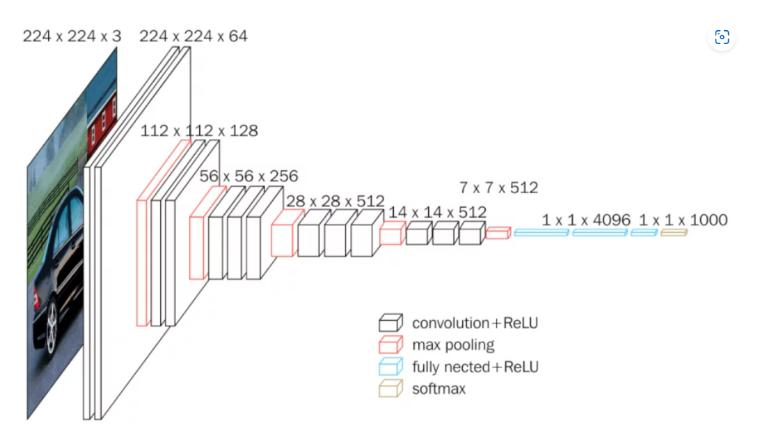



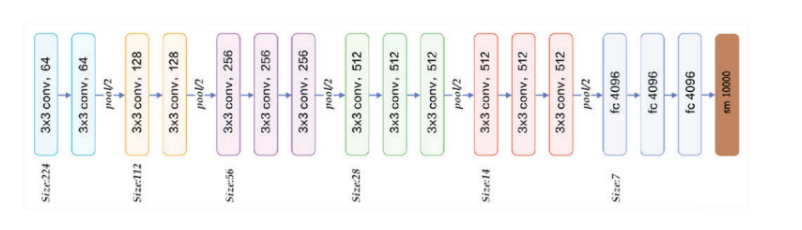

**Mô hình vgg16**

In [ ]:
base_model = tf.keras.applications.VGG16(
    weights=None,             # Mô hình chưa được đào tạo trước
    include_top=False,        # base_model không bao gồm các lớp Fully Connected
    input_shape=IMG_SIZE
)

# Thêm các tầng phân loại mới
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dense(1000, activation='relu'))
    # ngẫu nhiên "loại bỏ" một phần các đơn vị đầu vào trong quá trình huấn luyện
    # giảm hiện tượng overfitting
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))


In [ ]:

# Sau decay_steps, giảm tỷ lệ học một lần
decay_steps = 1000

# Tạo lịch trình học tập tùy chỉnh
learning_rate_schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[decay_steps],
    values=[LEARNING_RATE, LEARNING_RATE * DECAY_RATE]
)

# Xác định trình tối ưu hóa với lịch trình học tập tùy chỉnh
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_schedule, momentum=0.9)

# Compile mô hình
model.compile(optimizer=optimizer,
              # Tính toán sự khác biệt giữa xác xuất dự đoán và thực tế
              loss='categorical_crossentropy',
              metrics=['accuracy'])


#**Huấn Luyện**

In [ ]:
# Chuẩn bị dữ liệu huấn luyện
def convert_positive_to_negative_example(image_path):
    image = cv2.imread(image_path)
    # Dùng face_recognition để phát hiện khuôn mặt và các điểm đặc trưng
    face_landmarks_list = face_recognition.face_landmarks(image)

# Kiểm tra xem có khuôn mặt nào được phát hiện hay không
    result = image
    for i in range(0, len(face_landmarks_list)):
        # Lấy danh sách các điểm đặc trưng của khuôn mặt đầu tiên
        face_landmarks = face_landmarks_list[i]

        # Lấy các điểm đặc trưng của khuôn mặt
        eyebrow_left = face_landmarks['left_eyebrow']
        eyebrow_right = face_landmarks['right_eyebrow']
        eye_left = face_landmarks['left_eye']
        eye_right = face_landmarks['right_eye']
        nose = face_landmarks['nose_tip']
        lip = face_landmarks['bottom_lip']

    # cắt hình
        # Tính toán tọa độ góc trái trên của hình ảnh mới
        top_left_x = min(eyebrow_left[0][0], eye_left[0][0], nose[0][0], lip[6][0])
        top_left_y = image.shape[:2][1]
        for i in range(0, 5):
            top_left_y = min(top_left_y, eyebrow_left[i][1], eyebrow_right[i][1])

        # Tính toán tọa độ góc phải dưới của hình ảnh mới
        bottom_right_x = max(eyebrow_right[-1][0], eye_right[3][0], nose[0][0], lip[0][0])
        bottom_right_y = 0
        for i in range(0, 12):
            bottom_right_y = max(bottom_right_y, lip[i][1])

        #xét điều kiện tránh cắt ra ngoài ảnh
        top_left_x = max(top_left_x, 0)
        top_left_y = max(top_left_y, 0)
        bottom_right_x = min(bottom_right_x, image.shape[:2][0])
        bottom_right_y = min(bottom_right_y, image.shape[:2][1])

        cropped_image = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        cropped_image_size = cropped_image.shape[:2]

        # Phóng to hoặc thu nhỏ ảnh ngẫu nhiên
        scale_factor = random.uniform(0.5, 1.5)  # Tính toán tỷ lệ ngẫu nhiên
        resized_image = cv2.resize(cropped_image, None, fx=scale_factor, fy=scale_factor)

        # Ghép lại ảnh ban đầu
        resized_image = cv2.resize(resized_image, (cropped_image_size[1], cropped_image_size[0])) # Trả lại kích thước ban đầu cho ảnh đã cắt
        image[top_left_y:bottom_right_y, top_left_x:bottom_right_x] = resized_image  # Đặt ảnh đã bị cắt vào vị trí ảnh cắt lúc đầu trong ảnh gốc

    #Áp dụng làm mờ cho vùng mặt nạ được vẽ gồm lông mày và môi dưới
        # Tạo mặt nạ
        mask_points = np.concatenate((eyebrow_right[-1], lip[0], lip[1], lip[2], lip[3], lip[4], lip[5], lip[6], eyebrow_left[0]), axis=0).reshape(-1, 2)

        for i in range(1, 5):
            if eyebrow_left[i-1][1] > eyebrow_left[i][1]:
                mask_points = np.concatenate((mask_points, np.expand_dims(eyebrow_left[i], axis=0)), axis=0)

        for i in range(1, 5):
            if eyebrow_right[-i][1] > eyebrow_right[-i-1][1]:
                mask_points = np.concatenate((np.expand_dims(eyebrow_right[-i-1], axis=0), mask_points), axis=0)

        # Tạo mask ban đầu
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [mask_points.astype(np.int32)], 255)

        # Mở rộng mask để cắt thêm phần xung quanh
        kernel_size = 5  # Kích thước kernel dilation
        border_size = 10  # Kích thước viền
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
        expanded_mask = cv2.dilate(mask, kernel, iterations=border_size)

        # Cắt vùng đã chọn từ hình ảnh gốc
        face_cut = cv2.bitwise_and(image, image, mask=expanded_mask)

        # Áp dụng hiệu ứng làm mờ Gaussian cho vùng đã được cắt ra
        blurred_face = cv2.GaussianBlur(face_cut, (5, 5), 0)

        mask = np.expand_dims(mask, axis=2)
        result = np.where(mask == 0, image, blurred_face)
    return result


In [ ]:
#tạo ra batch

def batch_generator(data_dir, batch_size):
    file_list = os.listdir(data_dir)
    num_samples = len(file_list)
    num_batches = num_samples // batch_size
    batches = []
    def generator():
        for batch_index in range(num_batches):
            start_index = batch_index * batch_size
            end_index = (batch_index + 1) * batch_size
            batch_files = file_list[start_index:end_index]

            x_batch = []
            y_batch = []

            # Lấy ngẫu nhiên nửa số lượng ví dụ tích cực
            positive_examples = np.random.choice(batch_files, size=batch_size//2, replace=False)

            for file_name in batch_files:
                # Đường dẫn đầy đủ của hình ảnh
                image_path = os.path.join(data_dir, file_name)
                image = cv2.imread(image_path)

                if file_name not in positive_examples and len(face_recognition.face_locations(image)) > 0:
                    image = convert_positive_to_negative_example(image_path)
                    # Tiền xử lý ảnh
                    # Thay đổi kích thước ảnh
                    image = cv2.resize(image, (224, 224))

                    # Chuẩn hóa pixel
                    image -= np.array(PIXEL_MEAN, dtype=np.uint8)
                    label = 1
                    x_batch.append(image)
                    y_batch.append(label)
                else :
                    # Tiền xử lý ảnh
                    # Thay đổi kích thước ảnh
                    image = cv2.resize(image, (224, 224))

                    # Chuẩn hóa pixel
                    image -= np.array(PIXEL_MEAN, dtype=np.uint8)
                    label = 0
                    x_batch.append(image)
                    y_batch.append(label)

            x_batch = np.array(x_batch)
            y_batch = tf.keras.utils.to_categorical(y_batch, num_classes=2)

            yield x_batch, y_batch

    dataset = tf.data.Dataset.from_generator(generator, output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.uint8),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32)
    ))

    return dataset


In [ ]:
eval_data_dir = "/content/drive/MyDrive/eval_data"
eval_dataset = batch_generator(eval_data_dir, 8)

batch_size = 64
data_dir = "/content/drive/MyDrive/positive_example"

num_epochs = 10
batch_size = 64
loss_values = []
accuracy_values = []
best_accuracy = 0.0  # Biến để theo dõi độ chính xác tốt nhất

for epoch in range(num_epochs):
    for x_batch, y_batch in batch_generator(data_dir, batch_size):
        model.train_on_batch(x_batch, y_batch)

    # Đánh giá mô hình trên tập validation
    val_loss, val_accuracy = model.evaluate(eval_dataset)

    loss_values.append(val_loss)
    accuracy_values.append(val_accuracy)

    # In thông tin về epoch
    print(f"Epoch {epoch+1}/{num_epochs} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

    # Kiểm tra nếu độ chính xác hiện tại tốt hơn độ chính xác tốt nhất
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        # Lưu lại trạng thái của mô hình
        model.save_weights("/content/drive/MyDrive/best_model.h5")


25/25 [==============================] - 55s 2s/step - loss: 0.6912 - accuracy: 0.5700
Epoch 1/10 - val_loss: 0.6912 - val_accuracy: 0.5700
25/25 [==============================] - 13s 519ms/step - loss: 0.6916 - accuracy: 0.5100
Epoch 2/10 - val_loss: 0.6916 - val_accuracy: 0.5100
25/25 [==============================] - 11s 450ms/step - loss: 0.6725 - accuracy: 0.6100
Epoch 3/10 - val_loss: 0.6725 - val_accuracy: 0.6100
25/25 [==============================] - 13s 503ms/step - loss: 0.5394 - accuracy: 0.7200
Epoch 4/10 - val_loss: 0.5394 - val_accuracy: 0.7200
25/25 [==============================] - 11s 415ms/step - loss: 0.4747 - accuracy: 0.7650
Epoch 5/10 - val_loss: 0.4747 - val_accuracy: 0.7650
25/25 [==============================] - 11s 451ms/step - loss: 0.3936 - accuracy: 0.8350
Epoch 6/10 - val_loss: 0.3936 - val_accuracy: 0.8350
25/25 [==============================] - 12s 464ms/step - loss: 0.3720 - accuracy: 0.8150
Epoch 7/10 - val_loss: 0.3720 - val_accuracy: 0.8150
25

In [ ]:
for epoch in range(num_epochs, num_epochs +10):
    for x_batch, y_batch in batch_generator(data_dir, batch_size):
        model.train_on_batch(x_batch, y_batch)

    # Đánh giá mô hình trên tập validation
    val_loss, val_accuracy = model.evaluate(eval_dataset)

    loss_values.append(val_loss)
    accuracy_values.append(val_accuracy)

    # In thông tin về epoch
    print(f"Epoch {epoch+1}/{2*num_epochs} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

    # Kiểm tra nếu độ chính xác hiện tại tốt hơn độ chính xác tốt nhất
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        # Lưu lại trạng thái của mô hình
        model.save_weights("/content/drive/MyDrive/best_model.h5")

# **Đánh giá mô hình**

In [ ]:
# Vẽ biểu đồ loss của train và validation
plt.plot(range(1, 2*num_epochs+1), loss_values, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Vẽ biểu đồ độ chính xác của train và validation
plt.plot(range(1, 2*num_epochs+1), accuracy_values, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()